In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

import re
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch

import itertools
import string

import numpy as np

from IPython.display import clear_output
from matplotlib import pyplot as plt
from nltk.tokenize import WordPunctTokenizer

from sklearn.manifold import TSNE
import plotly.express as px

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
russian_stopwords = stopwords.words("russian")

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [ ]:
!pip install pymorphy2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 48.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=5b1e21e8e296ba46fcc28b34623a7d3af65a886a05d865cdf0f732e4dc2b35b0
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


Загрузим подготовленный в предыдущем ноутбуке датасет

In [ ]:
df = pd.read_csv('//content/drive/MyDrive/df_spell_corrected_22_01.csv')
df

,doc_name,doc_text
0,"Распоряжение, федеральный уровень, глава испол...",распоряжение президента российской федерации о...
1,"Распоряжение, федеральный уровень, глава испол...",распоряжение президента российской федерации о...
2,"Указ, федеральный уровень, глава исполнительно...",указ президента российской федерации об освобо...
3,"Распоряжение, федеральный уровень, глава испол...",распоряжение президента российской федерации о...
4,"Распоряжение, федеральный уровень, глава испол...",распоряжение президента российской федерации о...
...,...,...
22886,"Указ, региональный уровень, глава исполнительн...",губернатор орловской области у к аз о мерах по...
22887,"Указ, региональный уровень, глава исполнительн...",ммжхжчмитжкъщ а г х м башкортостан республи...
22888,"Указ, региональный уровень, глава исполнительн...",у к а з губернатора пермского края об отмене...
22889,"Указ, региональный уровень, глава исполнительн...",у к а з губернатора пермского края г об утве...


In [ ]:
texts = df['doc_text'][:50].tolist()
texts[30]

'указ президента российской федерации о назначении на должность сотрудников федеральной противопожарной службы государственной противопожарной службы  назначить генерал майора внутренней службы киржакова игоря федоровича начальником главного управления министерства российской федерации по делам гражданской обороны чрезвычайным ситуациям и ликвидации последствий стихийных бедствий по томской области освободив его от занимаемой должности генерал майора внутренней службы клименко валерия ивановича начальником главного управления министерства российской федерации по делам гражданской обороны чрезвычайным ситуациям и ликвидации последствий стихийных бедствий по калужской области освободив его от занимаемой должности генерал майора внутренней службы кузнецова анатолия владимировича начальником главного управления министерства российской федерации по делам гражданской обороны чрезвычайным ситуациям и ликвидации последствий стихийных бедствий по новосибирской области освободив его от занимаемо

In [ ]:
tokenizer = WordPunctTokenizer()
import pymorphy2
morph = pymorphy2.MorphAnalyzer()
print(tokenizer.tokenize(texts[30]))

['указ', 'президента', 'российской', 'федерации', 'о', 'назначении', 'на', 'должность', 'сотрудников', 'федеральной', 'противопожарной', 'службы', 'государственной', 'противопожарной', 'службы', 'назначить', 'генерал', 'майора', 'внутренней', 'службы', 'киржакова', 'игоря', 'федоровича', 'начальником', 'главного', 'управления', 'министерства', 'российской', 'федерации', 'по', 'делам', 'гражданской', 'обороны', 'чрезвычайным', 'ситуациям', 'и', 'ликвидации', 'последствий', 'стихийных', 'бедствий', 'по', 'томской', 'области', 'освободив', 'его', 'от', 'занимаемой', 'должности', 'генерал', 'майора', 'внутренней', 'службы', 'клименко', 'валерия', 'ивановича', 'начальником', 'главного', 'управления', 'министерства', 'российской', 'федерации', 'по', 'делам', 'гражданской', 'обороны', 'чрезвычайным', 'ситуациям', 'и', 'ликвидации', 'последствий', 'стихийных', 'бедствий', 'по', 'калужской', 'области', 'освободив', 'его', 'от', 'занимаемой', 'должности', 'генерал', 'майора', 'внутренней', 'служ

In [ ]:
def tokenize_lemmatize(text):
    text_tokens = tokenizer.tokenize(text)
    res = list()
    for word in text_tokens:
        p = morph.parse(word)[0]
        if len(p.normal_form)>3:
          res.append(p.normal_form)

    return ' '.join(res)

print(tokenize_lemmatize(texts[30]))

указ президент российский федерация назначение должность сотрудник федеральный противопожарный служба государственный противопожарный служба назначить генерал майор внутренний служба киржакова игорь фёдорович начальник главное управление министерство российский федерация дело гражданский оборона чрезвычайный ситуация ликвидация последствие стихийный бедствие томский область освободить занимать должность генерал майор внутренний служба клименко валерий иванович начальник главное управление министерство российский федерация дело гражданский оборона чрезвычайный ситуация ликвидация последствие стихийный бедствие калужский область освободить занимать должность генерал майор внутренний служба кузнецов анатолий владимирович начальник главное управление министерство российский федерация дело гражданский оборона чрезвычайный ситуация ликвидация последствие стихийный бедствие новосибирский область освободить занимать должность генерал майор внутренний служба осипенко михаил иванович начальник г

In [ ]:
df['text_token'] = df['doc_text'].apply(tokenize_lemmatize)
df

In [ ]:
df.to_csv('/content/drive/MyDrive/df_token_lemm_22_01.csv', index=False)

Для красивой визуализации: сначала картинка со всеми словами из датасета

<Axes: >

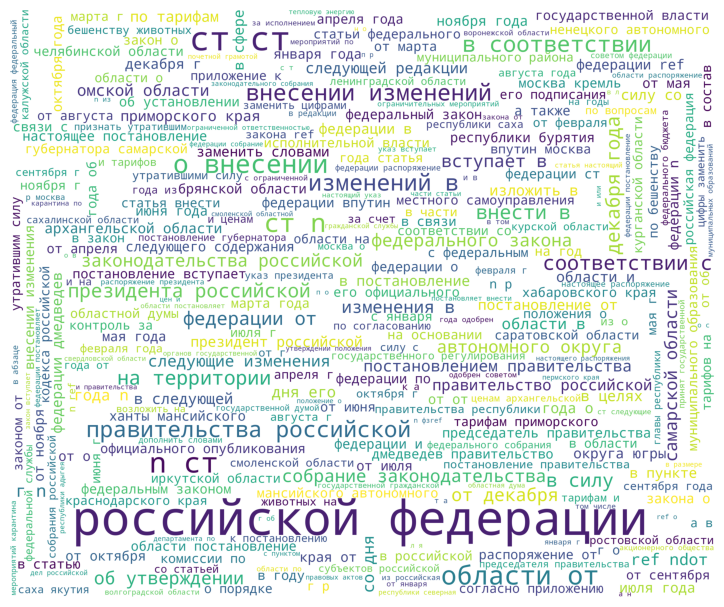

In [ ]:
%matplotlib inline


from wordcloud import WordCloud, STOPWORDS

def get_corpus(data):
    corpus = []
    for phrase in data:
        for word in phrase.split():
            corpus.append(word)
    return corpus



# Получение текстовой строки из списка слов
def str_corpus(corpus):
    str_corpus = ''
    for i in corpus:
        str_corpus += ' ' + i
    str_corpus = str_corpus.strip()
    return str_corpus

def get_wordCloud(corpus):
    wordCloud = WordCloud(background_color='white',
                              stopwords=STOPWORDS,
                              width=3000,
                              height=2500,
                              max_words=300,
                              random_state=42
                         ).generate(str_corpus(corpus))
    return wordCloud
corpus = get_corpus(df['doc_text'].values)
procWordCloud = get_wordCloud(corpus)

fig = plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.imshow(procWordCloud)
plt.axis('off')

plt.subplot(1, 2, 1)

После удаления стоп-слов и слов, короче 3 символов (например, "ст")

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
russian_stopwords = stopwords.words("russian")


df['text_token_filtred'] = df['text_token'].map(lambda x: [token for token in x.split() if token not in russian_stopwords\
                                                                  and token != " "\
                                                                  and len(token)>3] )
df['text_token_filtred'] = df['text_token_filtred'].map(lambda x: ' '.join(x))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
corpus_clean = get_corpus(df['text_token_filtred'].values)
procWordCloud = get_wordCloud(corpus_clean)

<Axes: >

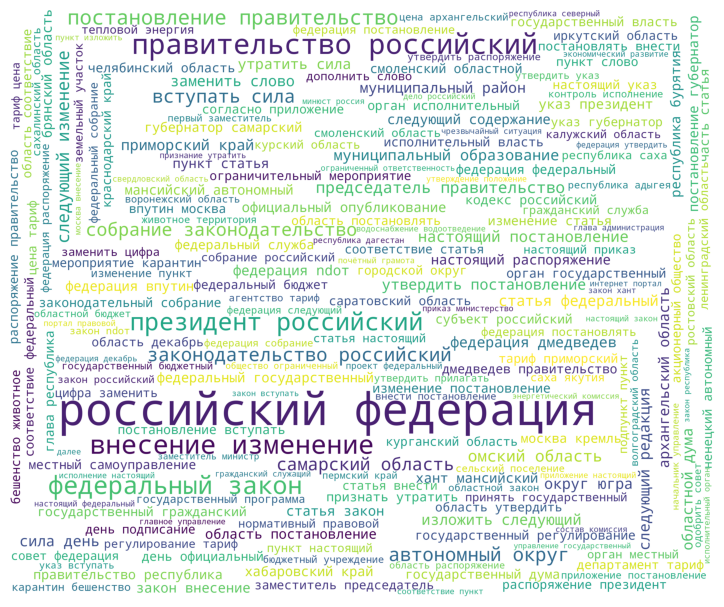

In [ ]:
fig = plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.imshow(procWordCloud)
plt.axis('off')

plt.subplot(1, 2, 1)

In [ ]:
len(corpus), len(corpus_clean)

Попробуем классифицировать тексты классическими ML-алгоритмами: логистической регрессией, SGD и случайным лесом

In [ ]:
df = pd.read_csv('//content/drive/MyDrive/df_difficult_26_01.csv')

Для визуалиции распределния признаков, полученным td-idf, с количеством n-gramm, найденным CV при обучении

In [ ]:
tfidf  = TfidfVectorizer(ngram_range=(1,4))
tfidf.fit([' '.join(i) for i in df['text_token_filtred'].str.split()])
X_train, X_valid, y_train, y_valid = train_test_split(df['text_token_filtred'], df['doc_name'], test_size=0.2, random_state=42)
X_idf = tfidf.transform(X_train)
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300, init='random')
tsne_results = tsne.fit_transform(X_idf[:1500])
fig = px.scatter(
    tsne_results, x=0, y=1,
    color=y_train[:1500], labels={'color': 'Вид НПА'}
)
fig.show()

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1500 samples in 0.002s...
[t-SNE] Computed neighbors for 1500 samples in 367.047s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1500
[t-SNE] Computed conditional probabilities for sample 1500 / 1500
[t-SNE] Mean sigma: 0.279307
[t-SNE] KL divergence after 50 iterations with early exaggeration: 71.072311
[t-SNE] KL divergence after 300 iterations: 1.214886


In [ ]:
def print_metrics(test, preds):
  print(metrics.classification_report(test, preds))
  print(metrics.accuracy_score(test, preds), 'accuracy')
  print(metrics.precision_score(test, preds, average='macro'), 'precision')
  print(metrics.recall_score(test, preds, average='macro'), 'recall')
  print(metrics.f1_score(test, preds, average='macro'), 'f1')

In [ ]:
lr_ppl_clf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('lr_clf', LogisticRegression(random_state=42))
])

parameters = {
              'lr_clf__solver':['lbfgs', 'newton-cg', 'sag', 'saga'],
              'lr_clf__class_weight':[None, 'balanced'],
              'lr_clf__penalty':[None, 'l2', 'l1', 'elasticnet'],
              'tfidf__strip_accents':['ascii', 'unicode', None],
               'tfidf__ngram_range':[(1,1),(1,2), (1,3), (1,4)]
              }
model = GridSearchCV(lr_ppl_clf, parameters, cv=4, n_jobs=-1).fit(X_train[:1000], y_train[:1000])
print('Best score and parameter combination:')
print(model.best_score_, model.best_params_)

In [ ]:
lr_ppl_clf = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 4), strip_accents='unicode')),
    ('lr_clf', LogisticRegression(solver='newton-cg',penalty=None, class_weight='balanced', random_state=42))
])
lr_ppl_clf.fit(X_train, y_train)
predicted_lr_val = lr_ppl_clf.predict(X_valid)
print_metrics(y_valid, predicted_lr_val)

Не такие уж и плохие результаты для регрессии!


Теперь SGD

In [ ]:
sgd_ppl_clf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('sgd_clf', SGDClassifier(random_state=42))
])

parameters = {
              'sgd_clf__loss':['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
              'sgd_clf__class_weight':[None, 'balanced'],
              'sgd_clf__penalty':[None, 'l2', 'l1', 'elasticnet'],
              'tfidf__strip_accents':['ascii', 'unicode', None],
               'tfidf__ngram_range':[(1,1),(1,2), (1,3), (1,4)]
              }
model = GridSearchCV(sgd_ppl_clf, parameters, cv=4, n_jobs=-1).fit(X_train[:1000], y_train[:1000])
print('Best score and parameter combination:')
print(model.best_score_, model.best_params_)

In [ ]:
sgd_ppl_clf = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 4), strip_accents='unicode')),
    ('sgd_clf', SGDClassifier(loss='hinge',penalty='l1', class_weight='balanced', random_state=42))
])
sgd_ppl_clf.fit(X_train, y_train)


predicted_sgd_val = sgd_ppl_clf.predict(X_valid)
print_metrics(y_valid, predicted_sgd_val)


                                                                   precision    recall  f1-score   support

               Закон, региональный уровень, законодательный орган       0.95      0.99      0.97       308
                Закон, федеральный уровень, законодательный орган       1.00      1.00      1.00       282
 Постановление, региональный уровень, глава исполнительной власти       0.95      0.92      0.94       306
       Постановление, региональный уровень, законодательный орган       0.99      0.97      0.98       288
Постановление, региональный уровень, органы исполнительной власти       0.97      0.95      0.96       199
               Постановление, региональный уровень, правительство       0.92      0.92      0.92       285
                Постановление, федеральный уровень, правительство       0.99      1.00      0.99       254
       Приказ, региональный уровень, органы исполнительной власти       0.95      0.95      0.95       283
        Приказ, федеральный уровень,

In [ ]:
fr_ppl_clf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('rf_clf', RandomForestClassifier(random_state=42))
])

parameters = {
              'rf_clf__n_estimators':[ 300, 500, 700],
              'rf_clf__max_depth':[5, 8, 11, 14],
              'rf_clf__criterion':['gini', 'entropy', 'log_loss'],
              'tfidf__strip_accents':['ascii', 'unicode', None],
               'tfidf__ngram_range':[(1,1),(1,2), (1,3), (1,4)]
              }
model = GridSearchCV(fr_ppl_clf, parameters, cv=4, n_jobs=-1).fit(X_train[:1000], y_train[:1000])
print('Best score and parameter combination:')
print(model.best_score_, model.best_params_)

In [ ]:
fr_ppl_clf = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 4), strip_accents=None)),
    ('sgd_clf', RandomForestClassifier(n_estimators=700,max_depth=14, criterion='log_loss', random_state=42))
])
fr_ppl_clf.fit(X_train, y_train)


ppredicted_fr_val = fr_ppl_clf.predict(X_valid)
print_metrics(y_valid, ppredicted_fr_val)

                                                                   precision    recall  f1-score   support

               Закон, региональный уровень, законодательный орган       0.96      1.00      0.98       329
                Закон, федеральный уровень, законодательный орган       1.00      1.00      1.00       347
 Постановление, региональный уровень, глава исполнительной власти       0.97      0.87      0.92       318
       Постановление, региональный уровень, законодательный орган       0.98      0.94      0.96       302
Постановление, региональный уровень, органы исполнительной власти       0.99      0.90      0.94       244
               Постановление, региональный уровень, правительство       0.86      0.94      0.90       318
                Постановление, федеральный уровень, правительство       1.00      0.99      1.00       314
       Приказ, региональный уровень, органы исполнительной власти       0.97      0.94      0.95       325
        Приказ, федеральный уровень,

А если использовать только униграммы?

In [ ]:
tfidf  = TfidfVectorizer(ngram_range=(1,1))
tfidf.fit([' '.join(i) for i in df['text_token_filtred'].str.split()])
X_train, X_valid, y_train, y_valid = train_test_split(df['text_token_filtred'], df['doc_name'], test_size=0.2, random_state=42)
X_train = tfidf.transform(X_train)
X_valid = tfidf.transform(X_valid)

In [ ]:
lr_ppl_clf = Pipeline([

    ('lr_clf', LogisticRegression(random_state=42))
])

parameters = {
              'lr_clf__solver':['lbfgs', 'newton-cg', 'sag', 'saga'],
              'lr_clf__class_weight':[None, 'balanced'],
              'lr_clf__penalty':[None, 'l2', 'l1', 'elasticnet']
              }
model = GridSearchCV(lr_ppl_clf, parameters, cv=4, n_jobs=-1).fit(X_train[:1000], y_train[:1000])
print('Best score and parameter combination:')
print(model.best_score_, model.best_params_)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning:


56 fits failed out of a total of 128.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
8 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)


Best score and parameter combination:
0.849 {'lr_clf__class_weight': 'balanced', 'lr_clf__penalty': None, 'lr_clf__solver': 'sag'}


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



In [ ]:
lr_ppl_clf = Pipeline([

    ('lr_clf', LogisticRegression(solver='sag',penalty=None, class_weight='balanced', random_state=42))
])
lr_ppl_clf.fit(X_train, y_train)
predicted_lr_val = lr_ppl_clf.predict(X_valid)
print_metrics(y_valid, predicted_lr_val)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



                                                                   precision    recall  f1-score   support

               Закон, региональный уровень, законодательный орган       0.98      0.99      0.98       329
                Закон, федеральный уровень, законодательный орган       1.00      0.99      1.00       347
 Постановление, региональный уровень, глава исполнительной власти       0.98      0.97      0.98       318
       Постановление, региональный уровень, законодательный орган       0.99      0.97      0.98       302
Постановление, региональный уровень, органы исполнительной власти       0.99      0.98      0.98       244
               Постановление, региональный уровень, правительство       0.95      0.95      0.95       318
                Постановление, федеральный уровень, правительство       0.99      0.99      0.99       314
       Приказ, региональный уровень, органы исполнительной власти       0.98      0.99      0.99       325
        Приказ, федеральный уровень,

In [ ]:
sgd_ppl_clf = Pipeline([

    ('sgd_clf', SGDClassifier(random_state=42))
])

parameters = {
              'sgd_clf__loss':['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
              'sgd_clf__class_weight':[None, 'balanced'],
              'sgd_clf__penalty':[None, 'l2', 'l1', 'elasticnet']
              }
model = GridSearchCV(sgd_ppl_clf, parameters, cv=4, n_jobs=-1).fit(X_train[:1000], y_train[:1000])
print('Best score and parameter combination:')
print(model.best_score_, model.best_params_)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning:

The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.



Best score and parameter combination:
0.883 {'sgd_clf__class_weight': 'balanced', 'sgd_clf__loss': 'log', 'sgd_clf__penalty': 'l1'}


In [ ]:
sgd_ppl_clf = Pipeline([

    ('sgd_clf', SGDClassifier(loss='log',penalty='l1', class_weight='balanced', random_state=42))
])
sgd_ppl_clf.fit(X_train, y_train)


predicted_sgd_val = sgd_ppl_clf.predict(X_valid)
print_metrics(y_valid, predicted_sgd_val)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning:

The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.



                                                                   precision    recall  f1-score   support

               Закон, региональный уровень, законодательный орган       0.97      0.98      0.97       329
                Закон, федеральный уровень, законодательный орган       1.00      0.98      0.99       347
 Постановление, региональный уровень, глава исполнительной власти       0.96      0.95      0.96       318
       Постановление, региональный уровень, законодательный орган       0.99      0.95      0.97       302
Постановление, региональный уровень, органы исполнительной власти       0.96      0.97      0.96       244
               Постановление, региональный уровень, правительство       0.91      0.91      0.91       318
                Постановление, федеральный уровень, правительство       0.96      0.98      0.97       314
       Приказ, региональный уровень, органы исполнительной власти       0.96      0.95      0.96       325
        Приказ, федеральный уровень,

In [ ]:
fr_ppl_clf = Pipeline([

    ('rf_clf', RandomForestClassifier(random_state=42))
])

parameters = {
              'rf_clf__n_estimators':[ 300, 500, 700],
              'rf_clf__max_depth':[ 5, 8, 11, 14],
              'rf_clf__criterion':['gini', 'entropy', 'log_loss']
              }
model = GridSearchCV(fr_ppl_clf, parameters, cv=4, n_jobs=-1).fit(X_train[:1000], y_train[:1000])
print('Best score and parameter combination:')
print(model.best_score_, model.best_params_)

Best score and parameter combination:
0.875 {'rf_clf__criterion': 'gini', 'rf_clf__max_depth': 14, 'rf_clf__n_estimators': 300}


In [ ]:
fr_ppl_clf = Pipeline([

    ('sgd_clf', RandomForestClassifier(n_estimators=300,max_depth=14, criterion='gini', random_state=42))
])
fr_ppl_clf.fit(X_train, y_train)


ppredicted_fr_val = fr_ppl_clf.predict(X_valid)
print_metrics(y_valid, ppredicted_fr_val)

                                                                   precision    recall  f1-score   support

               Закон, региональный уровень, законодательный орган       0.93      1.00      0.96       329
                Закон, федеральный уровень, законодательный орган       1.00      1.00      1.00       347
 Постановление, региональный уровень, глава исполнительной власти       0.95      0.76      0.85       318
       Постановление, региональный уровень, законодательный орган       0.97      0.96      0.97       302
Постановление, региональный уровень, органы исполнительной власти       0.97      0.94      0.96       244
               Постановление, региональный уровень, правительство       0.80      0.87      0.83       318
                Постановление, федеральный уровень, правительство       0.99      0.99      0.99       314
       Приказ, региональный уровень, органы исполнительной власти       0.93      0.94      0.93       325
        Приказ, федеральный уровень,

Наблюдается слишком высокое качество классификации. Это связано с тем, что в начале текста документа есть прямое указание на вид НПА - несмотря на то, что это типичное оформление документа, встречающееся в практике, усложним задачу классификации тем, что уберем из текстов документа первые 6 токенов - в которых, как правило, и содержится наименование и тип акта.


In [ ]:
def remove_marks(text):
    tokens = text.split()
    res = tokens[10:-10]

    return ' '.join(res)


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/df_difficult_25_01.csv')
df['text_difficult'] = df['text_token_filtred'].apply(remove_marks)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/df_difficult_26_01.csv')

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(df['text_difficult'], df['doc_name'], test_size=0.2, random_state=42)

In [ ]:
lr_ppl_clf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('lr_clf', LogisticRegression(random_state=42))
])

parameters = {
              'lr_clf__solver':['lbfgs', 'newton-cg', 'sag', 'saga'],
              'lr_clf__class_weight':[None, 'balanced'],
              'lr_clf__penalty':[None, 'l2', 'l1', 'elasticnet'],
              'tfidf__strip_accents':['ascii', 'unicode', None],
               'tfidf__ngram_range':[(1,1),(1,2), (1,3), (1,4)]}

model = GridSearchCV(lr_ppl_clf, parameters, cv=4, n_jobs=-1).fit(X_train[:1000], y_train[:1000])
print('Best score and parameter combination:')
print(model.best_score_, model.best_params_)

In [ ]:
lr_ppl_clf = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 4), strip_accents='unicode')),
    ('lr_clf', LogisticRegression(solver='newton-cg',penalty=None, class_weight=None, random_state=42))
])
lr_ppl_clf.fit(X_train, y_train)


predicted_lr_val = lr_ppl_clf.predict(X_valid)
print_metrics(y_valid, predicted_lr_val)

                                                                   precision    recall  f1-score   support

               Закон, региональный уровень, законодательный орган       0.97      0.99      0.98       329
                Закон, федеральный уровень, законодательный орган       1.00      1.00      1.00       347
 Постановление, региональный уровень, глава исполнительной власти       0.96      0.97      0.97       318
       Постановление, региональный уровень, законодательный орган       0.99      0.96      0.98       302
Постановление, региональный уровень, органы исполнительной власти       0.99      0.98      0.98       244
               Постановление, региональный уровень, правительство       0.91      0.93      0.92       318
                Постановление, федеральный уровень, правительство       0.97      0.99      0.98       314
       Приказ, региональный уровень, органы исполнительной власти       0.96      0.97      0.96       325
        Приказ, федеральный уровень,

SGD

In [ ]:
sgd_ppl_clf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('sgd_clf', SGDClassifier(random_state=42))
])

parameters = {
              'sgd_clf__loss':['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
              'sgd_clf__class_weight':[None, 'balanced'],
              'sgd_clf__penalty':[None, 'l2', 'l1', 'elasticnet'],
              'tfidf__strip_accents':['ascii', 'unicode', None],
               'tfidf__ngram_range':[(1,1),(1,2), (1,3), (1,4)]
              }
model = GridSearchCV(sgd_ppl_clf, parameters, cv=4, n_jobs=-1).fit(X_train[:1000], y_train[:1000])
print('Best score and parameter combination:')
print(model.best_score_, model.best_params_)

Best score and parameter combination:
0.8089999999999999 {'sgd_clf__class_weight': 'balanced', 'sgd_clf__loss': 'hinge', 'sgd_clf__penalty': 'l1', 'tfidf__ngram_range': (1, 4), 'tfidf__strip_accents': None}


In [ ]:
sgd_ppl_clf = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 4), strip_accents=None)),
    ('sgd_clf', SGDClassifier(loss='hinge',penalty='l1', class_weight='balanced', random_state=42))
])
sgd_ppl_clf.fit(X_train, y_train)


ppredicted_sgd_val = sgd_ppl_clf.predict(X_valid)
print_metrics(y_valid, ppredicted_sgd_val)

                                                                   precision    recall  f1-score   support

               Закон, региональный уровень, законодательный орган       0.95      0.98      0.97       329
                Закон, федеральный уровень, законодательный орган       1.00      1.00      1.00       347
 Постановление, региональный уровень, глава исполнительной власти       0.94      0.91      0.92       318
       Постановление, региональный уровень, законодательный орган       0.96      0.96      0.96       302
Постановление, региональный уровень, органы исполнительной власти       0.95      0.95      0.95       244
               Постановление, региональный уровень, правительство       0.86      0.84      0.85       318
                Постановление, федеральный уровень, правительство       0.95      0.99      0.97       314
       Приказ, региональный уровень, органы исполнительной власти       0.85      0.92      0.89       325
        Приказ, федеральный уровень,

Random Forest

In [ ]:
fr_ppl_clf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('rf_clf', RandomForestClassifier(random_state=42))
])

parameters = {
              'rf_clf__n_estimators':[ 300, 500, 700, 900],
              'rf_clf__max_depth':[ 5, 8, 11],
              'rf_clf__max_features':['sqrt', 'log2', None],
              'tfidf__strip_accents':['ascii', 'unicode', None],
               'tfidf__ngram_range':[(1,1),(1,2), (1,3), (1,4)]
              }
model = GridSearchCV(fr_ppl_clf, parameters, cv=4, n_jobs=-1).fit(X_train[:1000], y_train[:1000])
print('Best score and parameter combination:')
print(model.best_score_, model.best_params_)

In [ ]:
fr_ppl_clf = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 4), strip_accents=None)),
    ('fr_clf', RandomForestClassifier(n_estimators=500,max_depth=11, max_features='sqrt', random_state=42))
])
fr_ppl_clf.fit(X_train, y_train)


ppredicted_fr_val = fr_ppl_clf.predict(X_valid)
print_metrics(y_valid, ppredicted_fr_val)

                                                                   precision    recall  f1-score   support

               Закон, региональный уровень, законодательный орган       0.92      0.99      0.96       329
                Закон, федеральный уровень, законодательный орган       0.98      1.00      0.99       347
 Постановление, региональный уровень, глава исполнительной власти       0.95      0.80      0.87       318
       Постановление, региональный уровень, законодательный орган       0.96      0.85      0.90       302
Постановление, региональный уровень, органы исполнительной власти       1.00      0.89      0.94       244
               Постановление, региональный уровень, правительство       0.77      0.88      0.82       318
                Постановление, федеральный уровень, правительство       0.87      0.99      0.93       314
       Приказ, региональный уровень, органы исполнительной власти       0.89      0.91      0.90       325
        Приказ, федеральный уровень,

только униграммы


In [ ]:
tfidf  = TfidfVectorizer(ngram_range=(1,1))
tfidf.fit([' '.join(i) for i in df['text_difficult'].str.split()])
X_train, X_valid, y_train, y_valid = train_test_split(df['text_difficult'], df['doc_name'], test_size=0.2, random_state=42)
X_train = tfidf.transform(X_train)
X_valid = tfidf.transform(X_valid)

In [ ]:
lr_ppl_clf = Pipeline([

    ('lr_clf', LogisticRegression(solver='newton-cg',penalty=None, class_weight=None, random_state=42))
])
lr_ppl_clf.fit(X_train, y_train)


predicted_lr_val = lr_ppl_clf.predict(X_valid)
print_metrics(y_valid, predicted_lr_val)

                                                                   precision    recall  f1-score   support

               Закон, региональный уровень, законодательный орган       0.96      0.99      0.98       329
                Закон, федеральный уровень, законодательный орган       0.99      0.99      0.99       347
 Постановление, региональный уровень, глава исполнительной власти       0.94      0.93      0.94       318
       Постановление, региональный уровень, законодательный орган       0.97      0.95      0.96       302
Постановление, региональный уровень, органы исполнительной власти       0.98      0.97      0.97       244
               Постановление, региональный уровень, правительство       0.90      0.86      0.88       318
                Постановление, федеральный уровень, правительство       0.95      0.98      0.96       314
       Приказ, региональный уровень, органы исполнительной власти       0.94      0.95      0.95       325
        Приказ, федеральный уровень,

In [ ]:
sgd_ppl_clf = Pipeline([

    ('sgd_clf', SGDClassifier(loss='hinge',penalty='l1', class_weight='balanced', random_state=42))
])
sgd_ppl_clf.fit(X_train, y_train)


ppredicted_sgd_val = sgd_ppl_clf.predict(X_valid)
print_metrics(y_valid, ppredicted_sgd_val)

                                                                   precision    recall  f1-score   support

               Закон, региональный уровень, законодательный орган       0.93      0.98      0.95       329
                Закон, федеральный уровень, законодательный орган       1.00      0.99      1.00       347
 Постановление, региональный уровень, глава исполнительной власти       0.94      0.94      0.94       318
       Постановление, региональный уровень, законодательный орган       0.98      0.94      0.96       302
Постановление, региональный уровень, органы исполнительной власти       0.93      0.97      0.95       244
               Постановление, региональный уровень, правительство       0.88      0.85      0.87       318
                Постановление, федеральный уровень, правительство       0.95      0.97      0.96       314
       Приказ, региональный уровень, органы исполнительной власти       0.91      0.94      0.92       325
        Приказ, федеральный уровень,

In [ ]:
fr_ppl_clf = Pipeline([

    ('fr_clf', RandomForestClassifier(n_estimators=500,max_depth=11, max_features='sqrt', random_state=42))
])
fr_ppl_clf.fit(X_train, y_train)


ppredicted_fr_val = fr_ppl_clf.predict(X_valid)
print_metrics(y_valid, ppredicted_fr_val)

                                                                   precision    recall  f1-score   support

               Закон, региональный уровень, законодательный орган       0.87      0.97      0.92       329
                Закон, федеральный уровень, законодательный орган       0.96      1.00      0.98       347
 Постановление, региональный уровень, глава исполнительной власти       0.96      0.71      0.82       318
       Постановление, региональный уровень, законодательный орган       0.94      0.89      0.91       302
Постановление, региональный уровень, органы исполнительной власти       0.97      0.91      0.94       244
               Постановление, региональный уровень, правительство       0.76      0.83      0.79       318
                Постановление, федеральный уровень, правительство       0.91      0.97      0.94       314
       Приказ, региональный уровень, органы исполнительной власти       0.93      0.92      0.93       325
        Приказ, федеральный уровень,